<a href="https://colab.research.google.com/github/SPThole/pyTrch/blob/master/pytorch_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Importing necessary libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn import MSELoss
import torch.nn as nn
from torch.nn.functional import sigmoid, relu, tanh
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression, make_classification, make_blobs, make_circles, make_moons
np.random.seed = 42

%matplotlib inline


# Helper classes, functions

In [61]:
class train_model:

  def __init__(self, 
               train_loader,
               test_loader,
               task,
               model,
               optimizer,
               criterion,
               epochs):
    
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.task = task
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = epochs
    self.model = model

  

  def train_it(self):
    """
    """
    history = {'train_loss':[],
                 'test_loss':[],
                 'train_score':[],
                 'test_score':[]}
    for epoch in range(self.epochs):

      for loader in self.train_loader:

        optimizer.zero_grad()

        xs, ys = loader

        preds = self.predict(xs)
        loss = self.criterion(self.predict(xs),ys)

        loss.backward()
        self.optimizer.step()
        
      model.eval()

      history['train_loss'].append(self.calc_loss(self.train_loader))
      history['test_loss'].append(self.calc_loss(self.test_loader))
      history['train_score'].append(self.calc_score(self.train_loader))
      history['test_score'].append(self.calc_score(self.test_loader))

      if epoch%100==0:
        print(f"Iteration : {epoch}")
        
        fig = plt.figure(figsize = (12,7))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], color = 'red', label = 'Training Loss')
        plt.plot(history['test_loss'], color = 'green', label = 'Validation Loss')
        plt.legend()
        

        plt.subplot(1, 2, 2)
        plt.plot(history['train_score'], color = 'red', label = 'Training Score')
        plt.plot(history['test_score'], color = 'green', label = 'Validation Score' )
        plt.legend()
        plt.show()
        

        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection = '3d')
        # ax.scatter(X[:,0], X[:,1], model(torch.tensor(X).float())[:,0].detach().numpy())
        # plt.show()
    return self.model, history

  def r2(self, ys, xs):

    return r2_score(ys, self.predict(xs).detach().numpy())
 
  def acc(self, ys, preds):
    maxs, cls = torch.max(preds, axis = 1)
    
    return torch.sum(cls==ys.reshape(-1,)).item()/ys.shape[0]

  def predict(self,xs):
    return self.model(xs)

  def calc_loss(self,loader):
    loss = []
    for idx, data in enumerate(loader):
      xs, ys = data
      loss.append(self.criterion(self.predict(xs).reshape(-1,),ys.reshape(-1,)).item())
    return np.mean(loss)

  def calc_score(self,loader):
    scores = []
    for data in loader:
      xs, ys = data
      if self.task == 'reg':
          scores.append(self.r2(ys,xs))
      else:
          scores.append(self.acc(ys,self.predict(xs)))
    return np.mean(scores)

  



In [62]:
class model_net(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):

    super(model_net, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.fc1 = nn.Linear(self.input_size, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 16)
    self.fc4 = nn.Linear(16, self.output_size)

  def forward(self,x):
    
    out = nn.functional.relu(self.fc1(x))
    out = nn.functional.relu(self.fc2(out))
    out = nn.functional.relu(self.fc3(out))
    out = self.fc4(out)

    return out

In [63]:
class mydata(DataLoader):

  def __init__(self, x, y):

    self.x = torch.tensor(x).float()
    self.y = torch.tensor(y.reshape(-1,1)).float()

  def __getitem__(self,idx):

    return self.x[idx], self.y[idx]

  def __len__(self):

    return len(self.x)

# Getting Data

In [64]:
from sklearn.datasets import load_boston
boston = load_boston()

In [69]:
X,Y = make_regression(1000,100,10,1)

In [70]:
# boston['data'].shape

In [71]:
Y = Y.reshape(-1,1)

# Define parameters

In [72]:

learning_rate = 0.01
batch_size = 32
hidden_size = 6
input_size = X.shape[1]
output_size = 1

In [74]:
dataset = mydata(X, Y)

train_dataset, test_dataset = random_split(dataset, [800,200])
train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset,batch_size=10)

In [75]:
model = model_net(input_size,hidden_size, output_size)

In [76]:
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
loss_func = nn.MSELoss()

# Training

Iteration : 0


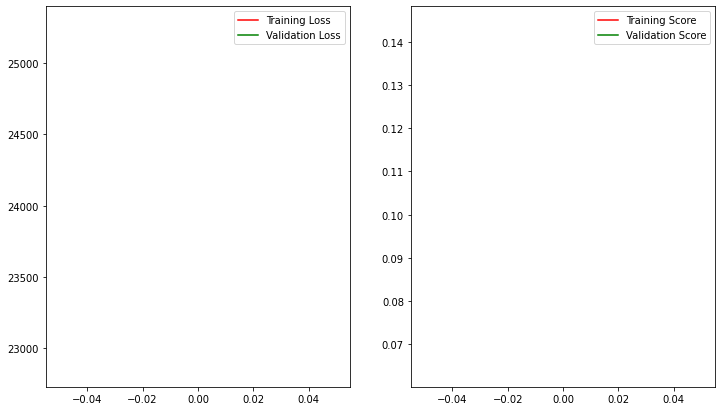

Iteration : 100


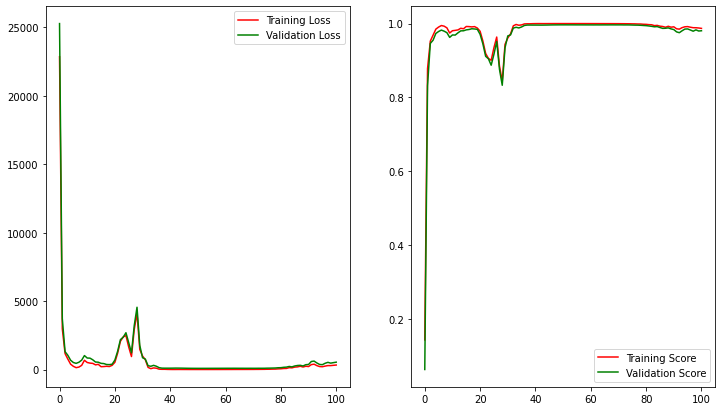

Iteration : 200


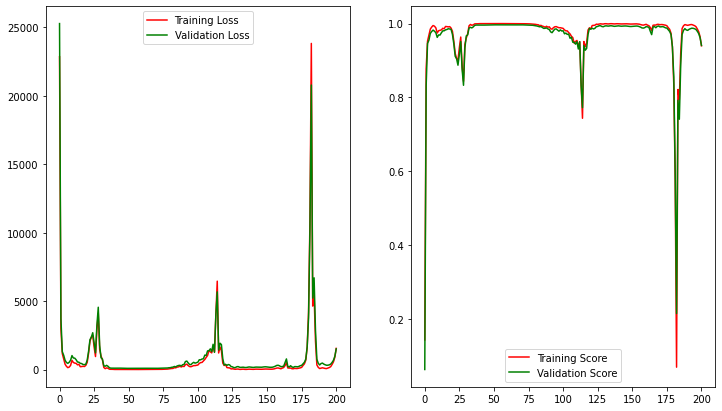

Iteration : 300


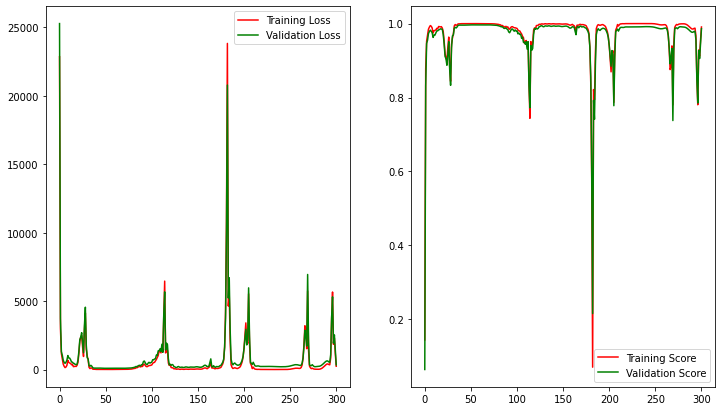

Iteration : 400


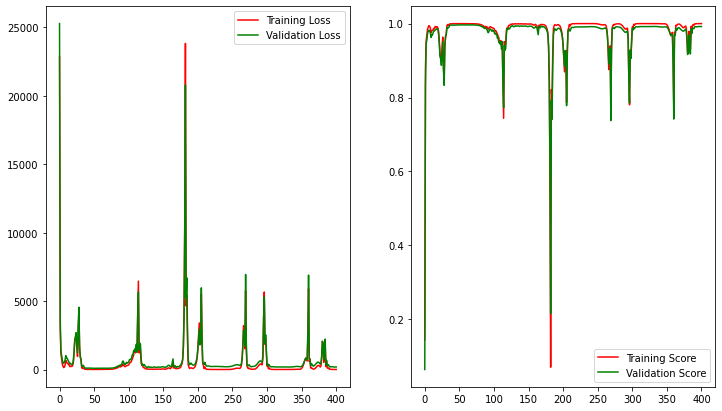

Iteration : 500


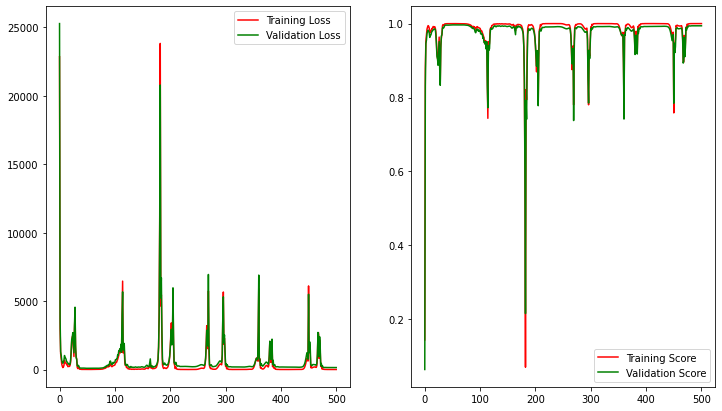

Iteration : 600


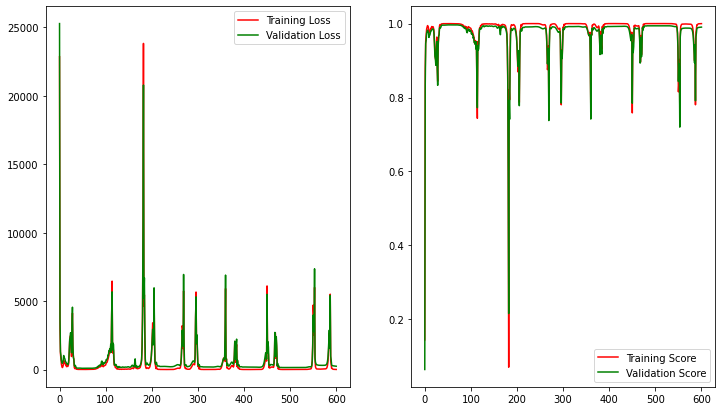

Iteration : 700


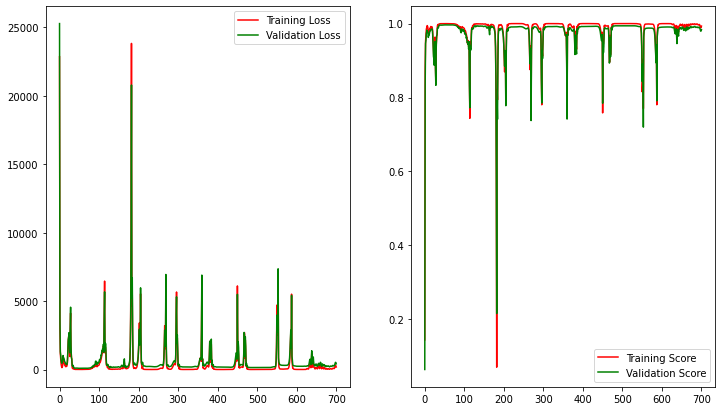

Iteration : 800


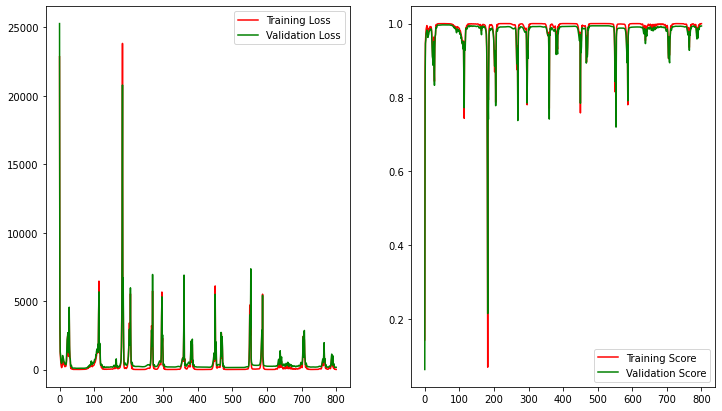

Iteration : 900


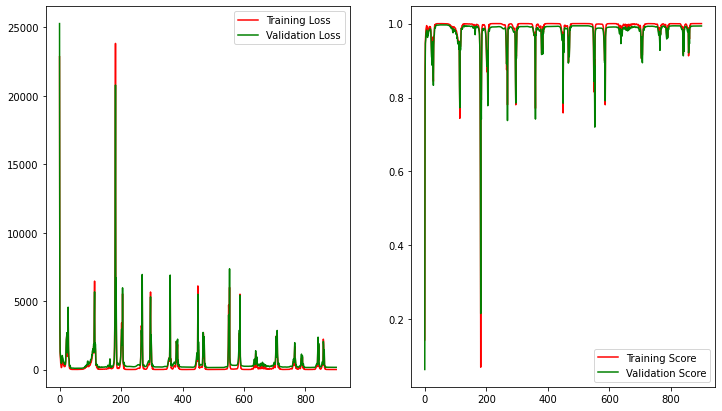

In [77]:
trainer = train_model(train_loader,
                      test_loader,
                      'reg',
                      model,
                      optimizer,
                      loss_func,
                      1000)
model, h = trainer.train_it()